<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import re
import datetime
import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

In [61]:
from google.colab import drive
drive.mount('/content/drive')

df_reviews = pd.read_csv('/content/drive/MyDrive/hotel_reviews/reviews.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# Drop date and reviewID columns
df_reviews.drop(columns=['Date', 'ReviewID'], inplace=True)

# Add column for average score (averaging ratings for each review)
cols = df_reviews.columns[:7]
df_reviews['average_score'] = df_reviews[cols].mean(axis=1).astype(int)

# Drop individual category ratings
df_reviews.drop(columns=cols, inplace=True)

In [63]:
df_reviews.head()

,Title,Content,average_score
0,“Super stay.”,This the second time we have stayed and this t...,5
1,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,4
2,“span pacific orchard”,Great hotel in good location for night life & ...,4
3,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,4
4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...",4


### Distrubution of average scores

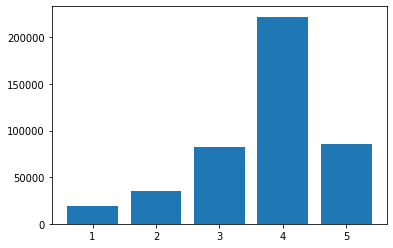

In [64]:
plt.bar([1, 2, 3, 4, 5], df_reviews['average_score'].value_counts().sort_index());

### Sample titles and descriptions by average score

In [65]:
import textwrap

wrapper = textwrap.TextWrapper(width=140)
for i in range(1, 6):
  print(f'Average Score: {i}')
  cond = df_reviews['average_score'] == i
  df_sample = df_reviews[cond].sample(5)
  for row in range(len(df_sample)):
    print(df_sample.iloc[row]['Title'], '\n')
    text = wrapper.wrap(df_sample.iloc[row]['Content'])
    for w in text:
      print(w)
    print('\n')
  print('*************\n')

Average Score: 1
“Sorry About That” 

I am now sick of the Hotels I will never stay in another one. We stayed in this so called helpful Travel Lodge for four nights this month
(Sep) and I was sick of hearing the staff say â€œsorry about thatâ€� Travel Lodge, just like any other Hotel, is interested in one thing,
and one thing only, profit no matter what. I thought you could not get blood out of a stone, but I am sure Travel Lodge knows how. The stay
We arrived about one hour before the booking in time. We were told if we book in early we would have to pay an extra Â£10. At first I said
â€œno wayâ€� I said â€œwe will sit here till the booking time of 3pm. Then I realised there was no seating or waiting area, and we could not
walk round as we have luggage, so we had to pay the extra Â£10, this was charged even though the room was ready. That was the start. Day Two
We went down for the continental breakfast that was Â£5.25 each. We paid then looked at what we could choose. There was empty

### Bucketize reviews into two sentiments, Good vs. Bad

It seems that 3 - 5 are generally favorable, and 1 - 2 are not.

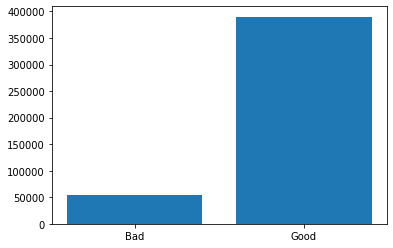

In [67]:
df_reviews['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3 else 0)
plt.bar(['Bad', 'Good'], df_reviews['sentiment'].value_counts().sort_index());